In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import os

In [31]:
path=r"C:\Users\STEVE\Desktop\papers\MOVES report"
dc=pd.read_csv(os.path.join(path,"DC.csv"))
trk1=pd.read_csv(os.path.join(path,'trk1.csv'))
trk1_2t=pd.read_csv(os.path.join(path,'trk1_2t.csv'))
dc.columns

Index(['t', 'mode', 'pl_pos', 'brk_sw', 'yaw_ang', 'sp', 'lat_acc', 'lon_acc',
       'yaw_rt', 'fuel_CANbus', 'steer_ang', 'weight', 'cacc_tgap', 'my_var',
       'STP', 'opt_m', 'MOVES_rates', 'MOVES_gr', 'MOVES_gl', 'E_gl', 'E_gr',
       '%E'],
      dtype='object')

In [32]:
for df in (dc, trk1, trk1_2t):
    df.drop(['brk_sw','mode','pl_pos','yaw_ang','lat_acc', 'steer_ang','weight','cacc_tgap','my_var','MOVES_gl','E_gl'
            , 'E_gr', '%E'], axis=1, inplace=True)
dc.columns

Index(['t', 'sp', 'lon_acc', 'yaw_rt', 'fuel_CANbus', 'STP', 'opt_m',
       'MOVES_rates', 'MOVES_gr'],
      dtype='object')

In [33]:

#trk1['mine']=None
def shift_time(w, input_list):
    w=w*10
    out=[]
    n=len(input_list)
    
    for i in range(n):
        if i<n-w: 
            out.append(input_list[i+int(w)])
        else: 
            out.append(input_list[i])
    return out



In [39]:
for df in (dc, trk1, trk1_2t):
    my_list=list(df.MOVES_gr)
    df['moves_shifted']=shift_time(.3, my_list)
    

In [40]:
acc, const, dec=1,0,-1
#############extract trk1
df1=trk1
trk1_const=df1[(df1.yaw_rt<0.02) & (400<=df1.t) & (df1.t<=500)]
trk1_acc=df1[(df1.yaw_rt<0.02) & (91.5<=df1.t) & (df1.t<=120)]
trk1_dec=df1[(df1.yaw_rt<0.02) & (3770<=df1.t) ]
trk1_const['trend']=const
trk1_dec['trend']=dec
trk1_acc['trend']=acc
df_trk1=pd.concat([trk1_const,trk1_acc, trk1_dec], axis=0)
df_trk1['task']='trk1'

#############extract trk1_2t
df1=trk1_2t
trk1_2t_const=df1[(df1.yaw_rt<0.02) & (500<=df1.t) & (df1.t<=620)]
trk1_2t_acc=df1[(df1.yaw_rt<0.02) & (219<=df1.t) & (df1.t<=250)]
trk1_2t_dec=df1[(df1.yaw_rt<0.02) & (3941<=df1.t) ]
trk1_2t_const['trend']=const
trk1_2t_dec['trend']=dec
trk1_2t_acc['trend']=acc
df_trk1_2t=pd.concat([trk1_2t_const,trk1_2t_acc, trk1_2t_dec], axis=0)
df_trk1_2t['task']='trk1_2t'
##########extract dc
df1=dc
dc_const1=dc[((dc.t>1050) & (dc.t<1250)) ]
dc_const2=dc[((dc.t>1520) & (dc.t<1720)) ]
dc_const=pd.concat([dc_const1,dc_const2 ], axis=0)

dc_dec=dc[dc.lon_acc<0]
dc_acc=dc[~dc.isin(pd.concat([dc_const1,dc_const2 , dc_dec], axis=0))]
dc_const['trend']=const
dc_dec['trend']=dec
dc_acc['trend']=acc
df_dc=pd.concat([dc_const , dc_dec, dc_acc], axis=0)
df_dc['task']='dc'
dff=pd.concat([df_dc , df_trk1, df_trk1_2t], axis=0)

C:\Users\STEVE\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\STEVE\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\STEVE\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-

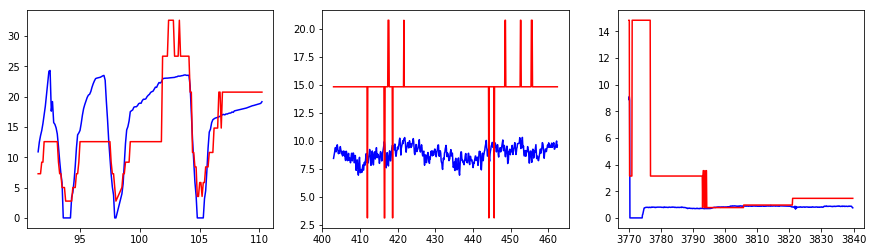

In [41]:
x,y_moves, y_CBD=[],[],[]
for df in [trk1_acc, trk1_const, trk1_dec]:    
    x.append(df.t)
    y_moves.append(df.fuel_CANbus)
    y_CBD.append(df.moves_shifted)

fig, ax=plt.subplots(1,3, figsize=(15,4))
for i in range(len(x)):
    ax[i].plot(x[i],y_moves[i], color='blue')
    ax[i].plot(x[i],y_CBD[i], color='red')
    
plt.show()
#basicplot(, df_dc.MOVES_gr)

In [211]:
def expo_smooth(acc_list, alpha):
    expo=[]
    for  n, a in enumerate(acc_list):
        if n==0:
            val=a
        else:
            val=alpha*a+(1-alpha)*expo[-1]
        expo.append(val)
    return expo
def MA(mylist, w):
    ma=[]
    for n in range(len(mylist)):
        if (n<int(w/2)) or (n>(len(mylist)-1-int(w/2))):
            val=mylist[n]
        else:
            l=np.array(mylist[n-int(w/2):n+1+int(w/2)])
            val=np.mean(l)
        ma.append(val)
    return ma
def compute_jerkindex(jerk_list,param):
    j_index=[]
    for j in jerk_list:
        if j==None: 
            j_index.append(None)
        elif abs(j)<param:
            j_index.append(0)
        else:
            j_index.append(np.sign(j))
    return j_index

def compute_jerk(acc_list, alpha, w, jerk_param):
    smoothed=expo_smooth(acc_list, alpha)
    low_pass=MA(smoothed,w)
    jerk=[]
    for i in range(len(low_pass)):
        if i==0:
            jerk.append(None)
        else:
            jerk.append((low_pass[i]-low_pass[i-1])/0.1)
    j_index=compute_jerkindex(jerk, jerk_param)
    return jerk, j_index


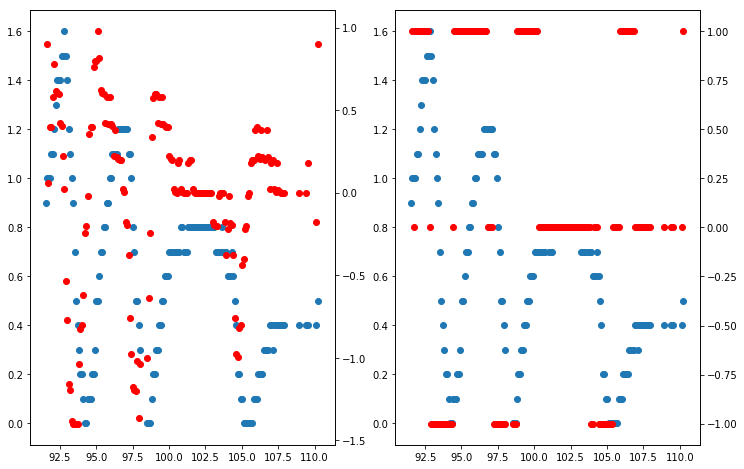

In [236]:
lon_acc_list=trk1_acc.lon_acc.tolist()
j, j_ind=compute_jerk(lon_acc_list,0.9,5,0.2)
fig, (ax1, ax3)=plt.subplots(1,2, figsize=(12,8))
ax1.scatter(df.t,df.lon_acc)
ax2 = ax1.twinx()
ax2.scatter(df.t,j, color='red')
ax3.scatter(df.t,df.lon_acc)
ax4 = ax3.twinx()
ax4.scatter(df.t,j_ind, color='red')
plt.show()

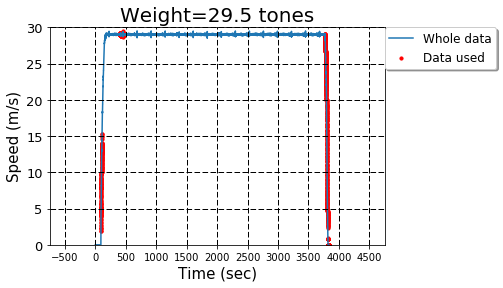

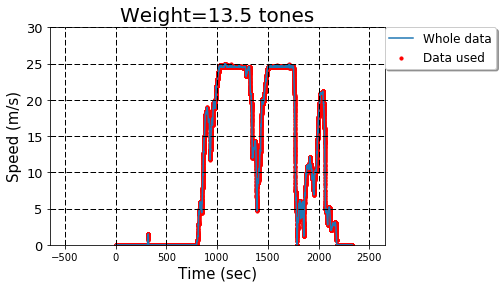

In [6]:

def plot_data(df,df_, title):
    fig, (ax1)=plt.subplots(1,1)
    line11=ax1.plot(df.t,df['sp'], label='Whole data')
    line12=ax1.scatter(df_.t,df_['sp'], color= 'red',s=10, label='Data used')
    ax1.set_ylabel('Speed (m/s)', size=15)
    ax1.set_xlabel('Time (sec)', size=15)
    
    ax1.set_ylim(0,30)
    #ax1.set_xlim(700,2200)
    
    
    legend1 = ax1.legend(bbox_to_anchor=(1, 1), loc=2,
           ncol=1, borderaxespad=0.,shadow=True, framealpha=1,  prop={'size':12})
    #ax1.set_xticklabels(np.arange(-500,3000,500),fontsize=13)
    ax1.set_yticklabels(np.arange(-5,35,5),fontsize=13)
    lw=1
    xmajorLocator = mtick.MultipleLocator(500)
    ymajorLocator = mtick.MultipleLocator(5)
    ax1.xaxis.set_major_locator(xmajorLocator)
    ax1.yaxis.set_major_locator(ymajorLocator)
    for xmaj in ax1.xaxis.get_majorticklocs():
        ax1.axvline(x=xmaj, ls='--', color='k', linewidth=lw)
    for ymaj in ax1.yaxis.get_majorticklocs():
        ax1.axhline(y=ymaj, ls='--', color='k',linewidth=lw)
    plt.title(title, fontsize=20)
    plt.show()
    
#plot_data(trk1_2t, df_trk1_2t,'Weight=50.6 tones' )
plot_data(trk1, df_trk1,'Weight=29.5 tones')
plot_data(dc, df_dc, 'Weight=13.5 tones')

In [7]:

def plot_fuel_data(df,df_, title):
    fig, (ax1)=plt.subplots(1,1)
    line11=ax1.plot(df.t,df['sp'], label='Whole data')
    line12=ax1.scatter(df_.t,df_['sp'], color= 'red',s=10, label='Data used')
    ax1.set_ylabel('Speed (m/s)', size=15)
    ax1.set_xlabel('Time (sec)', size=15)
    
    ax1.set_ylim(0,30)
    #ax1.set_xlim(700,2200)
    
    
    legend1 = ax1.legend(bbox_to_anchor=(1, 1), loc=2,
           ncol=1, borderaxespad=0.,shadow=True, framealpha=1,  prop={'size':12})
    #ax1.set_xticklabels(np.arange(-500,3000,500),fontsize=13)
    ax1.set_yticklabels(np.arange(-5,35,5),fontsize=13)
    lw=1
    xmajorLocator = mtick.MultipleLocator(500)
    ymajorLocator = mtick.MultipleLocator(5)
    ax1.xaxis.set_major_locator(xmajorLocator)
    ax1.yaxis.set_major_locator(ymajorLocator)
    for xmaj in ax1.xaxis.get_majorticklocs():
        ax1.axvline(x=xmaj, ls='--', color='k', linewidth=lw)
    for ymaj in ax1.yaxis.get_majorticklocs():
        ax1.axhline(y=ymaj, ls='--', color='k',linewidth=lw)
    plt.title(title, fontsize=20)
    plt.show()

In [153]:
#dff=dff[dff.fuel_CANbus>0]
dff[['%E', 'trend', 'task', 'jerk_index']].groupby(['task', 'trend'], as_index=False).agg(['mean', 'count'])

%E        jerk_index       
                    mean  count       mean  count
task    trend                                    
dc      -1     79.697397   1781  -0.106682   1781
         0     52.796508   3996   0.000000   3996
         1     22.861971  17511   0.005711  17511
trk1    -1     74.271058    670  -0.016418    670
         0      0.674785    595  -0.003361    595
         1     55.425430    166   0.240964    166
trk1_2t -1     68.058490    946   0.022199    946
         0      0.210327    598   0.010033    598
         1     24.658555    246   0.252033    246

In [155]:
dff[['%E', 'trend', 'task', 'jerk_index']].groupby(['task', 'trend'], as_index=False).agg(['mean', 'count'])

%E        jerk_index       
                    mean  count       mean  count
task    trend                                    
dc      -1     79.697397   1781  -0.106682   1781
         0     52.796508   3996   0.000000   3996
         1     22.861971  17511   0.005711  17511
trk1    -1     74.271058    670  -0.016418    670
         0      0.674785    595  -0.003361    595
         1     55.425430    166   0.240964    166
trk1_2t -1     68.058490    946   0.022199    946
         0      0.210327    598   0.010033    598
         1     24.658555    246   0.252033    246

In [142]:
dff[['sp','lon_acc', 'task']].groupby(['task'], as_index=False).agg(['min', 'max', 'mean', 'std'])

sp                               lon_acc                         
         min     max       mean        std     min  max      mean       std
task                                                                       
dc       0.0  24.969  10.080766  10.466640    -2.1  1.3 -0.007008  0.189508
trk1     0.0  29.429  19.408987  11.293776    -1.0  1.6 -0.075402  0.395724
trk1_2t  0.0  29.335  15.391782  11.821472    -1.3  0.7 -0.077598  0.274877

In [144]:
dff[['%E', 'trend', 'task', 'lon_acc']][dff.lon_acc<0.7].groupby(['task', 'trend'], as_index=False).mean()

,task,trend,%E,lon_acc
0,dc,-1,79.697397,-0.396182
1,dc,0,52.796508,0.000025
2,dc,1,22.973538,0.026710
3,trk1,-1,74.271058,-0.316567
4,trk1,0,0.674785,0.000840
5,trk1,1,115.216697,0.291250
6,trk1_2t,-1,68.058490,-0.222622
7,trk1_2t,0,0.210327,0.000167
8,trk1_2t,1,25.179855,0.282573


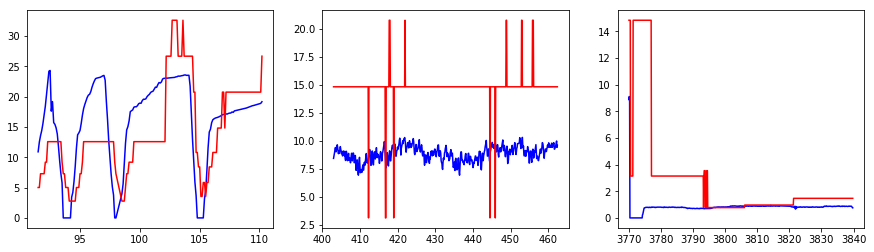

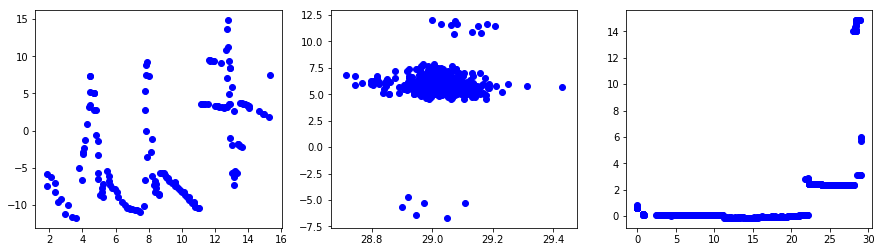

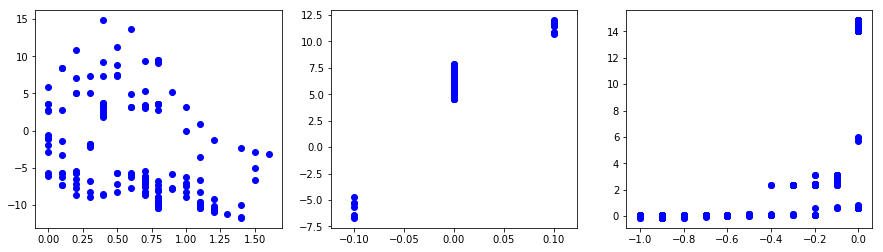

In [32]:
v_1,v_2, v_3=[],[],[]
for df in [trk1_acc, trk1_const, trk1_dec]:    
    v_3.append(df.E_gr)
    v_1.append(df.sp)
    v_2.append(df.lon_acc)

fig, ax=plt.subplots(1,3, figsize=(15,4))
fig, ax1=plt.subplots(1,3, figsize=(15,4))
for i in range(len(x)):
    ax[i].scatter(v_1[i],v_3[i], color='blue')
    #ax[i].scatter(v_2[i],v_3[i], color='red')
for i in range(len(x)):
    ax1[i].scatter(v_2[i],v_3[i], color='blue')
    #ax[i].plot(x[i]-0.3,y_CBD[i], color='red')
    
plt.show()
#basicplot(, df_dc.MOVES_gr)

In [29]:
def getA(M):
    CR0=0.006
    if M<14.968: CR0=CR0*0.0875/0.0661
    g=9.8
    M = M * 1000
    A=CR0*M*g
    return A/1000

def getC(M, CD=None):
    CR2 = 0.43 * 10 ** -5
    if M<14.968: CR2=CR2*5.90/4.21
    if CD==None: CD=0.57
    g=9.8
    Af=10.7
    ru=1.2
    M = M * 1000
    C=ru*Af*CD/2+CR2*M*g
    return C/1000

def VSP_coef1(M):
    fscale=17.1
    A=getA(M)
    B=0
    return A, B, fscale
def VSP_coef2(M, CD=None):
    return getC(M)

def VSP(M, v, a, CD=None):
    A, B, fscale=VSP_coef1(M)
    C=VSP_coef2(M, CD)
    vsp=(A*v+B*v**2+C*v**3+M*v*a)/fscale
    return vsp
#print(VSP(29.5, 29.167,0))

def getbin(v):
    ## v in m/s
    v_mph=v*3.6/1.6
    sp_bin=int(v_mph/25)+1
    return sp_bin


In [9]:
path="C:/Users/STEVE/Test_truck_data"
moves=pd.read_csv(path+"/Energy_MOVES_.csv")
moves.columns=['op','bin', 'VSP_low', 'VSP_high', 'E']
density=3167 #(gr/gallon)
E_content=43.717 #(KJ/gr)
moves['F']=moves.E/E_content*10**6/3600 #gr/sec

moves

,op,bin,VSP_low,VSP_high,E,F
0,0,0,NaN,NaN,0.231128,1.468586
1,1,0,NaN,NaN,0.114341,0.726521
2,11,1,-3.0,0.0,0.151903,0.965193
3,12,1,0.0,3.0,0.436716,2.774893
4,13,1,3.0,6.0,0.789210,5.014640
5,14,1,6.0,9.0,1.146648,7.285800
6,15,1,9.0,12.0,1.446522,9.191199
7,16,1,12.0,33.0,1.978998,12.574551
8,21,2,-3.0,0.0,0.122028,0.775366
9,22,2,0.0,3.0,0.557860,3.544643


In [25]:
def getop(M,v,a):
    v_mph=v*3.6/1.6
    if v_mph<1: 
        m=moves[(moves.op==0)]
    elif a<-0.4: 
        m=moves[(moves.op==1)]
    else: 
        b=getbin(v)
        vsp=max(-2,VSP(M, v, a))
        print(vsp)
        m=moves[(moves.bin==b )& (moves.VSP_high>vsp) & (moves.VSP_low<vsp)]
    return m.op.values[0],m.E.values[0], m.F.values[0]

print(getop(13.5, 22.471,0))


4.338039101836384
(33, 0.494418, 3.1415315171062366)


In [19]:
df_dc[(df_dc.t>1000) & (df_dc.t<1010)]

,t,mode,pl_pos,brk_sw,yaw_ang,sp,lat_acc,lon_acc,yaw_rt,fuel_CANbus,...,my_var,STP,opt_m,MOVES_rates,MOVES_gr,MOVES_gl,E_gl,E_gr,%E,jerk_index
9997,1000.073,2,1,0,0.018,22.471,3.117,0.0,0.007,5.36216,...,1.2,4.338039,33,494418.0,3.141532,3.571049,-1.791111,-2.220628,-0.413359,0
9998,1000.173,2,1,0,0.018,22.471,3.074,0.0,0.007,5.67159,...,1.2,4.338039,33,494418.0,3.141532,3.571049,-2.100541,-2.530058,-0.445308,0
9999,1000.273,2,1,0,0.019,22.498,3.003,0.0,0.007,5.52318,...,1.2,4.350371,33,494418.0,3.141532,3.571049,-1.952131,-2.381648,-0.430430,0
10000,1000.374,2,1,0,0.020,22.504,2.968,0.0,0.007,5.38932,...,1.2,4.353115,33,494418.0,3.141532,3.571049,-1.818271,-2.247788,-0.416310,0
10001,1000.474,2,1,0,0.020,22.509,2.992,0.0,0.006,5.38932,...,1.2,4.355402,33,494418.0,3.141532,3.571049,-1.818271,-2.247788,-0.416310,0
10002,1000.574,2,1,0,0.021,22.526,2.945,0.0,0.004,5.38932,...,1.2,4.363186,33,494418.0,3.141532,3.571049,-1.818271,-2.247788,-0.416310,0
10003,1000.674,2,1,0,0.021,22.526,2.910,0.0,0.004,5.41551,...,1.2,4.363186,33,494418.0,3.141532,3.571049,-1.844461,-2.273978,-0.419127,0
10004,1000.774,2,1,0,0.022,22.542,2.976,0.0,0.005,5.38932,...,1.2,4.370522,33,494418.0,3.141532,3.571049,-1.818271,-2.247788,-0.416310,0
10005,1000.874,2,1,0,0.022,22.553,3.046,0.0,0.004,5.41551,...,1.2,4.375570,33,494418.0,3.141532,3.571049,-1.844461,-2.273978,-0.419127,0
10006,1000.974,2,1,0,0.023,22.567,2.996,0.0,0.006,5.38932,...,1.2,4.382001,33,494418.0,3.141532,3.571049,-1.818271,-2.247788,-0.416310,0


In [20]:
dc_agg_c=df_dc[['opt_m','jerk_index','fuel_CANbus','MOVES_gr']].groupby(["opt_m","jerk_index"]).count()
trk1_agg_c=df_trk1[['opt_m','jerk_index','fuel_CANbus','MOVES_gr']].groupby(["opt_m","jerk_index"]).count()
trk1_2t_agg_c=df_trk1_2t[['opt_m','jerk_index','fuel_CANbus','MOVES_gr']].groupby(["opt_m","jerk_index"]).count()

In [21]:
path_out='C:/Users/STEVE/Test_truck_data/aggdata/'
dc_agg_c.to_csv(path_out+'dc_agg_c.csv')
trk1_agg_c.to_csv(path_out+'trk1_agg_c.csv')
trk1_2t_agg_c.to_csv(path_out+'trk1_2t_agg_c.csv')

In [22]:
dc_agg=df_dc[['opt_m','jerk_index','fuel_CANbus','MOVES_gr']].groupby(["opt_m","jerk_index"]).mean()
trk1_agg=df_trk1[['opt_m','jerk_index','fuel_CANbus','MOVES_gr']].groupby(["opt_m","jerk_index"]).mean()
trk1_2t_agg=df_trk1_2t[['opt_m','jerk_index','fuel_CANbus','MOVES_gr']].groupby(["opt_m","jerk_index"]).mean()
dc_agg.to_csv(path_out+'dc_agg.csv')
trk1_agg.to_csv(path_out+'trk1_agg.csv')
trk1_2t_agg.to_csv(path_out+'trk1_2t_agg.csv')